<img align="left" src="./logo.png" width=300>

# `Phaser`: BCDI Phase retrieval with Python

## Created by: Siddharth Maddali
### Argonne National Laboratory
<a href="https://doi.org/10.5281/zenodo.4305131" style="float: left;"><img src="https://zenodo.org/badge/DOI/10.5281/zenodo.4305131.svg" alt="DOI"></a>

# BCDI phase retrieval with partial coherence correction (PCC)

In [1]:
import collections
import time
import warnings
import os
os.environ[ 'TF_CPP_MIN_LOG_LEVEL' ] = '3' 

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import tensorflow as tf


from argparse import Namespace
from matplotlib.colors import LogNorm
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial.transform import Rotation
from scipy.ndimage.measurements import label

try: 
    from pyfftw.interfaces.numpy_fft import fftshift, fftn, ifftn
except:
    from numpy.fft import fftshift, fftn, ifftn

import Phaser as phsr
import TilePlot as tp

In [2]:
%matplotlib inline

In [3]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## Recipe tips
For phasing with PCC, it's better to start the recipe with short bursts of interleaved ER + PCC. 
This is to ensure that both the object and the blurring kernel are quickly brought into the neighborhood of the correct solution, earlier than later. 
This particular recipe has the following breakdown: 

   * Wave 1: 10 ER followed by 10 PCC (1 shrinkwrap in between the ER section).
   * Wave 2: Longer stretches of ER and PCC. 
   * Wave 3: Even longer stretches of ER (200) with shrinkwrap in between. 
   * Wave 4: Final stretch of ER (200 iterations). 

In [4]:
wave_1 = '+'.join( [ 'ER:10+SR:%.2f:0.1+ER:5+PCC:10'%sig for sig in np.linspace( 3., 1., 20 ) ] ) # support should have converged pretty well by now
wave_2 = '+'.join( [ 'ER:50+PCC:20+ER:50' ] * 5 )
wave_3 = '+'.join( [ 'ER:200+SR:1.0:0.1' ] * 5 )
wave_4 = 'ER:200'
recipe = '+'.join( [ wave_1, wave_2, wave_3, wave_4 ] )
print( recipe )

ER:10+SR:3.00:0.1+ER:5+PCC:10+ER:10+SR:2.89:0.1+ER:5+PCC:10+ER:10+SR:2.79:0.1+ER:5+PCC:10+ER:10+SR:2.68:0.1+ER:5+PCC:10+ER:10+SR:2.58:0.1+ER:5+PCC:10+ER:10+SR:2.47:0.1+ER:5+PCC:10+ER:10+SR:2.37:0.1+ER:5+PCC:10+ER:10+SR:2.26:0.1+ER:5+PCC:10+ER:10+SR:2.16:0.1+ER:5+PCC:10+ER:10+SR:2.05:0.1+ER:5+PCC:10+ER:10+SR:1.95:0.1+ER:5+PCC:10+ER:10+SR:1.84:0.1+ER:5+PCC:10+ER:10+SR:1.74:0.1+ER:5+PCC:10+ER:10+SR:1.63:0.1+ER:5+PCC:10+ER:10+SR:1.53:0.1+ER:5+PCC:10+ER:10+SR:1.42:0.1+ER:5+PCC:10+ER:10+SR:1.32:0.1+ER:5+PCC:10+ER:10+SR:1.21:0.1+ER:5+PCC:10+ER:10+SR:1.11:0.1+ER:5+PCC:10+ER:10+SR:1.00:0.1+ER:5+PCC:10+ER:50+PCC:20+ER:50+ER:50+PCC:20+ER:50+ER:50+PCC:20+ER:50+ER:50+PCC:20+ER:50+ER:50+PCC:20+ER:50+ER:200+SR:1.0:0.1+ER:200+SR:1.0:0.1+ER:200+SR:1.0:0.1+ER:200+SR:1.0:0.1+ER:200+SR:1.0:0.1+ER:200


## Data load
The provided data file `data.mat` also contains a digital object named `crystal_4`, which will be used for the PCC demonstration.

In [5]:
mydata = Namespace( **sio.loadmat( 'data.mat' ) )

## Blurring kernel
Simulating a 3D Gaussian blurring kernel. 

In [6]:
conv = np.pi/180.
parms = [ 0.6, 0.7, 0.65, 30.*conv,  50.*conv, 45.*conv ]
cov2 = np.diag( [ x**2 for x in parms[:3] ] ) # covariance eigenvalues
axis = np.array( 
    [ 
        np.sin( parms[4] ) * np.cos( parms[5] ), 
        np.sin( parms[4] ) * np.sin( parms[5] ), 
        np.cos( parms[4] )
    ]
)
R = Rotation.from_rotvec( parms[3]*axis ).as_matrix()
C = R @ cov2 @ R.T # covariance matrix
y, x, z = np.meshgrid( *[ np.arange( -n//2., n//2. ) for n in mydata.crystal_4.shape ] )
pts = np.concatenate( tuple( arr.reshape( 1, -1 ) for arr in ( x, y, z ) ), axis=0 )
kernel = np.exp( -0.5 * ( pts * ( C @ pts ) ).sum( axis=0 ) ).reshape( mydata.crystal_4.shape )
kernel *= ( np.prod( parms[:3] ) / ( 2. * np.pi )**1.5 )
print( kernel.sum() ) # check if normalized

0.9999999999999999


Now applying the blurring kernel to the otherwise coherent diffraction pattern from the object `crystal_4`. 

In [7]:
temp1 = np.absolute( fftn( fftshift( mydata.crystal_4 ) ) )**2
temp2 = fftshift( kernel )
data_blurred = fftshift( np.absolute( ifftn( fftn( temp1 ) * fftn( temp2 ) ) ) )
data_blurred *= ( temp1.max() / data_blurred.max() )
signal = np.random.poisson( data_blurred * 3.e4 / data_blurred.max() )

Text(0.5, 1.0, 'Partially coherent\nsignal')

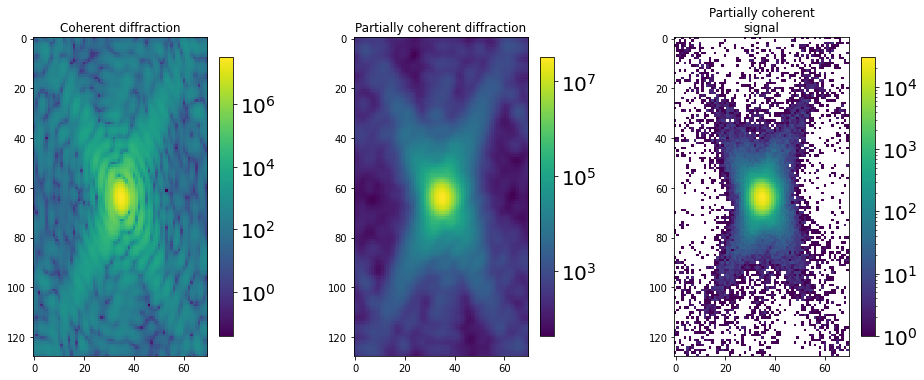

In [8]:
ax = tp.TilePlot( 
    tuple( this[64,:,:] for this in ( fftshift( temp1 ), data_blurred, signal ) ), 
    ( 1, 3 ), 
    ( 14, 5 ), 
    log_norm=True
)[-1]
ax[0].set_title( 'Coherent diffraction' )
ax[1].set_title( 'Partially coherent diffraction' )
ax[2].set_title( 'Partially coherent\nsignal' )

Designing the initial support for the phasing + PCC recipe as the [Patterson function](https://en.wikipedia.org/wiki/Patterson_function) of the signal. 

In [9]:
temp = np.log10( np.absolute( fftshift( fftn( fftshift( np.sqrt( signal ) ) ) ) ) )
mask = ( temp > 0.575*temp.max() ).astype( float )

In [10]:
labeled, features = label( mask )

In [11]:
support_label = list( dict( sorted( collections.Counter( labeled.ravel() ).items(), key=lambda item: -item[1] ) ).keys() )[1]
support = np.zeros( mask.shape )
support[ np.where( labeled==support_label ) ] = 1.

Text(0.5, 1.0, 'Estimated initial support')

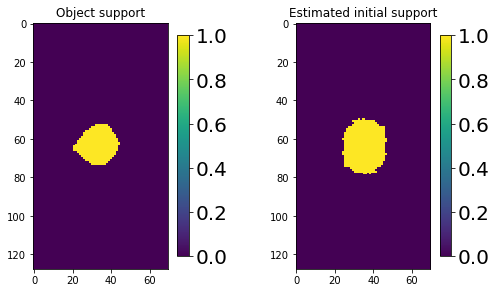

In [12]:
ax = tp.TilePlot( 
    tuple( this[64,:,:] for this in ( np.absolute( mydata.crystal_4 ), support ) ), 
    ( 1, 2 ), 
    ( 8, 4 )
)[-1] 

ax[0].set_title( 'Object support' )
ax[1].set_title( 'Estimated initial support' )

Now initializing the Phaser object on the GPU with the `pcc` flag.

In [13]:
solver = phsr.Phaser( modulus=np.sqrt( signal ), support=support, pcc=True, gpu=True ).gpusolver

In [14]:
tstart = time.time()
solver.runRecipe( recipe, show_progress=False )
tstop = time.time()

print( 'Time taken = %.2f seconds. '%( tstop - tstart ) )

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Time taken = 28.59 seconds. 


In [15]:
solver.Retrieve()

In [16]:
img = solver.finalImage
sup = solver.finalSupport

Text(0.5, 0.98, 'Reconstructed object')

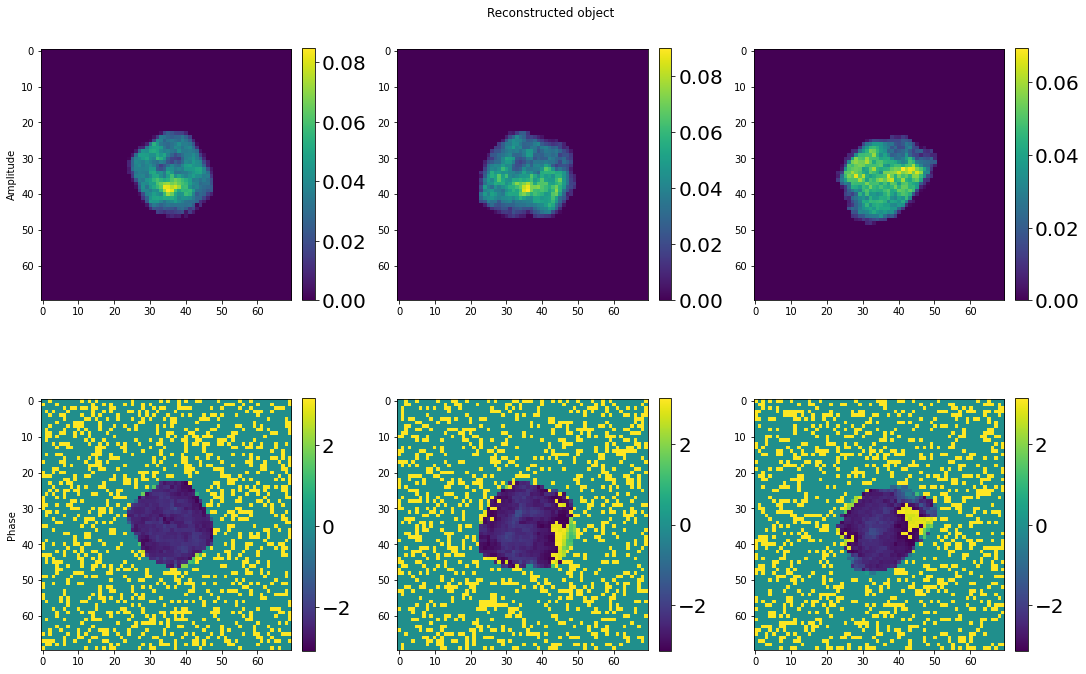

In [21]:
fig, im, ax = tp.TilePlot( 
    ( 
        np.absolute( img[29:99,29:99,35] ), np.absolute( img[ 29:99,64,:] ), np.absolute( img[64,29:99,:] ), 
        np.angle( img[29:99,29:99,35] ), np.angle( img[ 29:99,64,:] ), np.angle( img[64,29:99,:] ), 
    ), 
    ( 2, 3 ), 
    ( 15, 10 )
);
ax[0].set_ylabel( 'Amplitude' )
ax[3].set_ylabel( 'Phase' )
fig.suptitle( 'Reconstructed object' )

Text(0.5, 0.98, 'Original object (twin of the reconstructed object)')

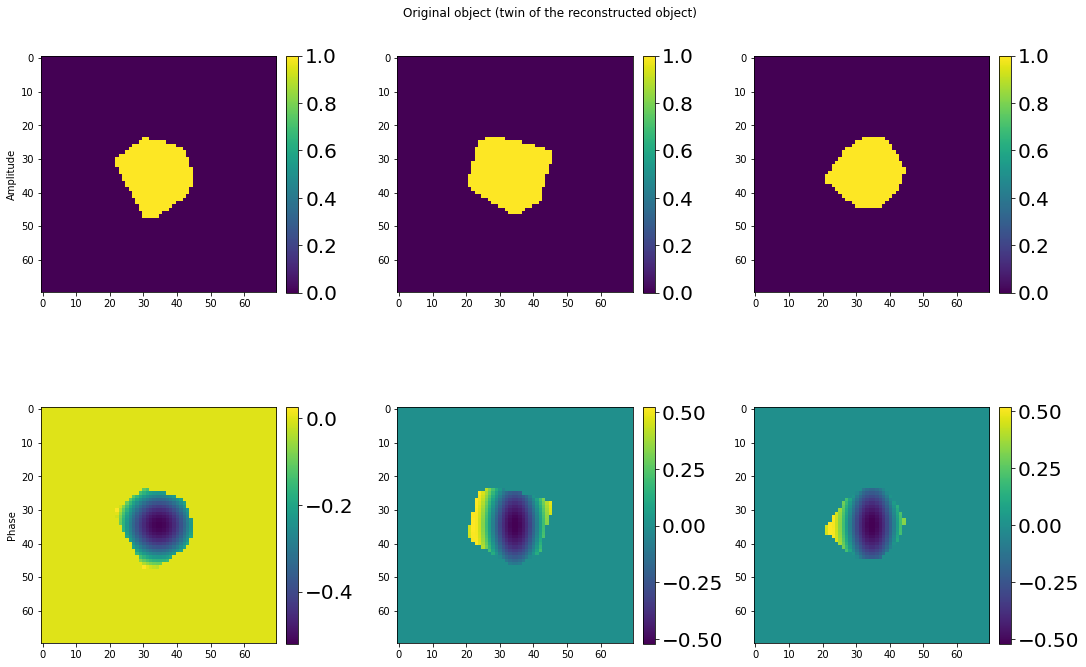

In [23]:
fig, im, ax = tp.TilePlot( 
    ( 
        np.absolute( mydata.crystal_4[29:99,29:99,35] ), np.absolute( mydata.crystal_4[ 29:99,64,:] ), np.absolute( mydata.crystal_4[64,29:99,:] ), 
        np.angle( mydata.crystal_4[29:99,29:99,35] ), np.angle( mydata.crystal_4[ 29:99,64,:] ), np.angle( mydata.crystal_4[64,29:99,:] ), 
    ), 
    ( 2, 3 ), 
    ( 15, 10 )
);
ax[0].set_ylabel( 'Amplitude' )
ax[3].set_ylabel( 'Phase' )
fig.suptitle( 'Original object (twin of the reconstructed object)' )